# Chainer の基礎

本章では、ディープラーニングフレームワーク Chainer の基本的な機能を使って、Chainer を使った訓練がどのような処理で構成されているかを簡潔に紹介します。
Chainer を用いた訓練の工夫や、GPUを利用した訓練、`Trainer` クラスを使った簡潔な訓練コードの記述方法などの発展的な内容は次章以降に紹介します。

Colab では予め Chainer がインストールされているため環境構築の必要はありません。
もし自分の PC 等に Chaier をインストールしたい場合は、[chainer.org](https://chainer.org/) の Quick Start に書かれた手順を参考にインストールしてください。



## Chainer とは

Chainer はオープンソースのディープラーニングフレームワークです。
こちらのGithubリポジトリ：[chainer/chainer](https://github.com/chainer/chainer) で活発に開発が行われています。
**オープンソースソフトウェア (open source software; OSS)** であるため、誰でも Chainer の全てのコードを見ることができます。

ディープラーニングフレームワークとは、これまでの章で説明してきたようなニューラルネットワークの設計・訓練・評価などに必要な一連の実装を容易にするためのフレームワークです（[注釈1](#note1)）。
特に層数の多いニューラルネットワークを GPU などを用いて高速に訓練できるようにする機能を備えたものを指すことが多く、Chainer の他にも様々なディープラーニングフレームワークが発表されています。

Chainer の大きな特徴として、「**Powerful (高性能)**」「**Flexibility (柔軟性)**」「**Intuitive (直感的)**」であることが挙げられます。ディープラーニングを学び始めたばかりの初学者から、新しい手法の発見を目指す研究者、実用的なシステムへの応用を行いたい開発者まで、多岐にわたるユーザが、様々なアイデアを試し、評価して、その結果に基づいてまた新たなアイデアを試す、という試行錯誤のループを高速に回せることを目指して、開発が進められています（[注釈2](#note2)）。

## Chainer の準備

Colab 上では Chainer は予めインストールされているため、ノートブックを開くとすでに Chainer のモジュールを読み込む準備が整っています。
最初にChainer を `import` して Chainer を使う準備をします。

In [1]:
import chainer

Chainer のバージョンや実行環境を確認します。
Chainer には `print_runtime_info()` という関数が用意されており、これを実行することでインストールされている Chainer のバージョンや、CuPy が利用可能か、などの情報を調べることができます。

In [2]:
chainer.print_runtime_info()

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy: Not Available
iDeep: 2.0.0.post3


## Chainerによる訓練

以降の説明では、簡単のためにニューラルネットワークをネットワークと呼びます。

Chainer によるネットワークの訓練は以下の 5 つのステップに分けられます。

- Step 1 : データセットの準備 
- Step 2 : ネットワークを決める
- Step 3 : 目的関数を決める
- Step 4 : 最適化手法を選択する
- Step 5 : ネットワークを訓練する

本章では、 scikit-learn に用意されている Iris データセットを利用し、アヤメの品種を分類する問題に取り組みます。
個々のステップについて以降で詳しく説明していきます。

### Step 1 : データセットの準備

ここでは Iris データセットの読み込みからデータセットの分割までを行います。

#### データセットの読み込み

`sklearn.datasets` モジュールにある `load_iris()` 関数を実行すると、150 個のアヤメの萼片の幅・長さ、花びらの幅・長さのデータと、それぞれのアヤメの種類を示すクラス IDが返ってきます。 これをそれぞれ `x` と `t` という変数で受け取って、それぞれの配列の形を表示してみます。

In [3]:
from sklearn.datasets import load_iris

# Iris データセットの読み込み
x, t = load_iris(return_X_y=True)

print('x:', x.shape)
print('t:', t.shape)

x: (150, 4)
t: (150,)


Iris データセットについて詳しく知りたい方はこちらをご覧ください。参考：[Iris plants dataset](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)


#### データの形式を Chainer に合わせる

Chainer のデフォルトでは、入力値のデータ型は `numpy.float32`、分類問題では目標値のデータ型は `numpy.int32` になっている必要があります。
そこで、これに合わせるためデータセットのデータ型を変更します。
`numpy.ndarray` は `astype()` メソッドを使ってデータ型を変更することができます。

In [4]:
# それぞれデータ型を変換
x = x.astype('float32')  
t = t.astype('int32')  

#### データセットの分割

scikit-learn の `sklearn.model_selection` モジュールで定義されている `train_test_split()` という関数を使い、データセットを「訓練データセット」「検証データセット」「テストデータセット」の 3 つに分割します。

まず全体を訓練データセットと検証データセットを合わせたものとテストデータセットの 2 つに分割します。
このときテストデータセットのサンプルサイズが全体の 30% になるように `test_size=0.3` と指定します。

In [5]:
# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

次に訓練データセットと検証データセットに分割します。
検証データセットは訓練データセットと検証データセットを合わせたもののうち 30% になるようにします。

In [6]:
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

### Step 2 : ネットワークを決める

ここでは訓練に使用するネットワークを決めます。

本章以降では、ネットワークを構成する「層 (layer) 」という言葉を、これまでの説明で用いてきたノードの集まりに対してではなく、訓練可能なパラメータを持つ関数に対して用います。

よって下の図のネットワークは、全結合層 1 つからなる 1 層のネットワークということになります。 

![ネットワークの定義](images/12/12_02.png)

「層」が何を指すかは文献によって異なっている場合もあるため、注意してください。

Chainer はニューラルネットワークの層を構成するための微分可能な関数を多く提供しています。
それらの関数は以下の 2 つに大別されます。

- パラメータを持つ関数 (層)：リンク
- パラメータを持たない関数：ファンクション

パラメータを持つ関数の例としては、上の図の全結合層のような層があります。一方、パラメータを持たない関数としては、シグモイド関数や ReLU 関数があります。

リンクは、`chainer.links` モジュール以下に、ファンクションは、`chainer.functions` モジュール以下に定義されています。

まずはこの二つのモジュールを読み込みます。


In [7]:
import chainer.links as L
import chainer.functions as F

#### Sequentialによるネットワーク定義

Chainer ではネットワークを作る方法がいくつか用意されています。
ここでは簡単にネットワークが作ることができる `Sequential` クラスを利用し、全結合層が 3 つ、活性化関数に ReLU 関数を利用したネットワーク `net` を作ります。

Chainerでは全結合層は `Linear` クラスとして定義されています。
これは以下のように、インスタンス化の際に入力の次元数と出力の次元数を引数に取ります。

In [8]:
# 入力次元数が 3、出力次元数が 2 の全結合層
l = L.Linear(3, 2)

また、ReLU 関数は `relu()` として定義されています。

それでは、`Sequential` クラスと `Linear` クラス、`relu()` を使ってネットワークを作ります。

Iris のデータは入力変数が 4 つですので、最初の全結合層の入力次元数が 4 になります。
また、Iris のクラス数は 3 なので、最後の全結合層の出力次元数は 3 です。

2 つ目の全結合層の入力次元数は任意の値を指定できますが、ここでは 6 としておきます。

In [9]:
from chainer import Sequential

# net としてインスタンス化
n_input = 4
n_hidden = 6
n_output = 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

### Step 3 : 目的関数を決める

訓練の際に利用する目的関数を決定します。
今回は、分類タスクによく利用される目的関数の中から、**交差エントロピー**を採用することにします。

ここでは、Chainerに定義されている `softmax_cross_entropy()` （[注釈3](#note3)）を利用します。

### Step 4 : 最適化手法を選択する

訓練を行う上で、最適化手法を選択する必要があります。

今回は、最適化手法として、**確率的勾配降下法 (SGD)** を利用します。
Chainer では `chainer.optimizers` に各最適化手法を実行するためのクラスが用意されており、確率的勾配降下法は `SGD` という名前で定義されています。

学習率 `lr` を 0.05としてインスタンス化し、`optimizer` という名前を付けます。

In [10]:
optimizer = chainer.optimizers.SGD(lr=0.05)

次に `optimizer` に `net` をセットして、`net` のパラメータが確率的勾配降下法によって更新されるようにします。

In [11]:
optimizer.setup(net)

### Step 5 : ネットワークを訓練する

Step 1 〜 Step 4 で準備したものを使ってネットワークの訓練を行います。
ネットワークの訓練を行う前に、訓練の際のエポック数とバッチサイズを決めます。ここではエポック数 `n_epoch` と バッチサイズ `n_batchsize` を以下のようにします。

In [12]:
n_epoch = 30
n_batchsize = 16

#### 訓練の実行

実際に訓練を実行します。
訓練は以下の処理を繰り返します。

1. 訓練用のバッチを準備
2. 予測値を計算し、目的関数を適用 (順伝播)
3. 勾配を計算 (逆伝播)
4. パラメータを更新

これに加えて、訓練がうまくいっているか判断するために、訓練データを利用した分類精度と検証データを利用した目的関数の値と分類精度を計算します。



In [13]:
import numpy as np

In [14]:
iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):
    
    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    
    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []
    
    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)
        
        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)
        
        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1
    
    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)
    
    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)
        
    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)
    
    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))
        
    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)
            
    

epoch: 0, iteration: 5, loss (train): 1.1461, loss (valid): 1.1007
epoch: 1, iteration: 10, loss (train): 1.0899, loss (valid): 1.0996
epoch: 2, iteration: 15, loss (train): 1.0789, loss (valid): 1.0944
epoch: 3, iteration: 20, loss (train): 1.0619, loss (valid): 1.0820
epoch: 4, iteration: 25, loss (train): 1.0321, loss (valid): 1.0576
epoch: 5, iteration: 30, loss (train): 0.9961, loss (valid): 1.0224
epoch: 6, iteration: 35, loss (train): 0.9238, loss (valid): 1.0020
epoch: 7, iteration: 40, loss (train): 0.9076, loss (valid): 0.9693
epoch: 8, iteration: 45, loss (train): 0.8813, loss (valid): 0.9445
epoch: 9, iteration: 50, loss (train): 0.8588, loss (valid): 0.9262
epoch: 10, iteration: 55, loss (train): 0.8303, loss (valid): 0.9069
epoch: 11, iteration: 60, loss (train): 0.8112, loss (valid): 0.8806
epoch: 12, iteration: 65, loss (train): 0.8043, loss (valid): 0.8546
epoch: 13, iteration: 70, loss (train): 0.7984, loss (valid): 0.8358
epoch: 14, iteration: 75, loss (train): 0.759

ここでは簡単のために、1エポックの内で使用してないサンプルサイズがバッチサイズ以下になったら次のエポックに移るようにしています。

上のコードで示したように、Chainer では勾配を計算する前に `net.cleargrads()` を実行し、一つ前の勾配を削除した後、`loss_train_batch.backward()` で勾配を計算します。 


また、検証データに対して予測値の計算を行う際には、`chainer.using_config('train', False)` と `chainer.using_config('enable_backprop', False)` の 2 つのスコープを指定しています（[注釈4](#note4)）。

訓練が終了したので、目的関数の出力値（交差エントロピー誤差）と分類精度がエポック毎にどのように変化したかを可視化します。まずは、目的関数の出力値を表示します。

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

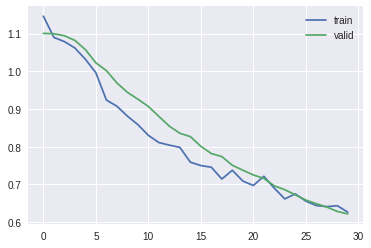

In [16]:
# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

横軸がエポック数、縦軸が目的関数の出力値になっています。グラフを見ると、訓練が進むにつれて目的関数の出力値（誤差）が減っており、訓練がうまくいっていることがわかります。

次に、分類精度を表示します。

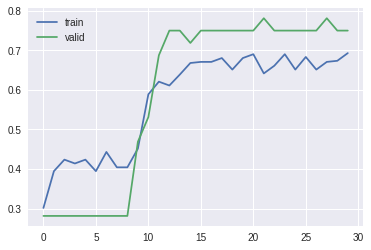

In [17]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

横軸がエポック数、縦軸が分類精度になっています。こちらのグラフでも訓練が進むにつれて分類精度が上がっており、訓練がうまくいっていることがわかります。

#### テストデータを用いた評価

訓練済みのネットワークを使ってテストデータに対する評価を行います。まずは、テストデータで予測を行います。検証用データのときと同様に `chainer.using_config('train', False)` と `chainer.using_config('enable_backprop', False)` を使います。

In [18]:
# テストデータで予測値を計算
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

予測ができたら分類精度を計算を確認します。

In [19]:
accuracy_test = F.accuracy(x_test, t_test)
accuracy_test.array

array(0.35555556, dtype=float32)

#### ネットワークの保存

最後に、訓練したネットワークを保存します。保存する場合は以下のようにします。

In [20]:
chainer.serializers.save_npz('my_iris.net', net)

`my_iris.net` という名前で保存しました。保存されたか確認します。

In [21]:
!ls

my_iris.net  sample_data


## 訓練済みネットワークを用いた推論

訓練済みのネットワークを用いてテストデータに対して推論を行います。

まずは保存したネットワークを読み込みます。
ネットワークを読み込むには、最初に訓練済みのネットワークと同様のクラスのインスタンスを作ります。

In [22]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

このネットワークのインスタンスに訓練済みのネットワークのパラメータを読み込ませます。

In [23]:
chainer.serializers.load_npz('my_iris.net', loaded_net)

訓練済みのネットワークの準備ができたら、実際に推論を行います。推論を行う際は検証用データのときと同様に `chainer.using_config('train', False)`、`chainer.using_config('enable_backprop', False)` を使います。

In [24]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

テストデータに対して推論ができたので、テストデータの `0` 番目のサンプルの予測結果を確認してみます。分類では以下のようにして、予測されたラベルを出力できます。

In [25]:
np.argmax(y_test[0,:].array)

2

本章では、Chainer を用いたモデルの訓練、及び推論の基本的な使い方を解説しました。

次章では、モデルの精度改善や訓練時間の短縮を行うための、より実践的な機能について紹介していきます。

<hr />

<div class="alert alert-info">
**注釈 1**

**フレームワーク**の定義については、**制御の反転 (inversion of control)** という概念がキーになります。
ライブラリの場合は、ライブラリ側が制御フローを持っているのではなくユーザが書いた制御フローの中で要素となる処理を担うためにその機能が呼ばれるという使われ方になりますが、フレームワークの場合は、**フレームワーク側が制御フローを持っていて、その要素となる処理についてユーザがコードを記述し、そのコードがフレームワーク側から呼ばれる**という構造を持ちます。（参考：[Inversion of control](https://en.wikipedia.org/wiki/Inversion_of_control)）

[▲上へ戻る](#ref_note1)
</div>

<div class="alert alert-info">
**注釈 2**

より具体的な特徴として、以下のようなものがあります。

- 試行錯誤のループを高速に回すには、思い浮かんだアイデアをソースコードに落とし込む作業がすばやく行えることが重要です。そのために Chainer は、<b>全ての機能が直感的なインターフェースを備えている</b>ように、また<b>数式とコードの間で記述が大きく乖離しないように</b>、注意深くデザインされています。
- 試行錯誤の過程で<b>間違ったコードを書いてしまったときにも、どの箇所が間違っているのかが発見しやすくなっている</b>ことも重要です。Chainer は、<b>エラーメッセージを分かりやすくし、デバッグ用の機能を提供する</b>などでこれを助けます。
- 実装したアイデアが思ったとおりの効果を上げるどうかを調べるための実験を短い時間で終えられれば、次のアイデアを試すまでの時間も短くなり、結果として試行錯誤のループを高速に回すことができます。そのためには、実験結果が出るまでに掛かる時間を短くする必要があります。Chainer は、<b>時間の掛かる計算を複数のマシンやデバイスに分散させて高速に処理する</b>機能や、状況に合わせて少ない手間で様々な処理を最適化する機能も持っており、一つの実験結果が出るまでの時間を短くする色々な方法が提供されています。
- ニューラルネットワークが訓練されていく過程で出力される様々な値を、視覚的にチェックすることができる <b>ChainerUI という拡張パッケージによって、 試行錯誤のループに直感的な判断を加えることが容易に</b>なります。
- ディープラーニングは様々な分野で応用されており、扱われるデータの種類や組み合わされるアルゴリズムの種類は多岐にわたります。 Chainer では画像認識、化学・生物学、強化学習などの分野における応用をスムーズに開始できるように以下の拡張ライブラリも提供しています。
    - **画像認識タスク向けに ChainerCV**
    - **化学・生物学分野向けに Chainer Chemistry**
    - **深層強化学習のために ChainerRL**
    
これらのライブラリでは、それぞれの分野にディープラーニングを応用するための便利な機能や、最先端の手法の実装コード、学習済みニューラルネットワークなどが商用利用も可能な自由な形で提供されているため、<b>各分野への入門から研究への活用、そして実用アプリケーションの開発に至るまで</b>、広く利用することができます。
- ディープラーニングにはニューラルネットワークを訓練する段階と、できあがったニューラルネットワークを活用する推論の段階があり、Chainer は推論を行う際に便利な機能やエコシステムもサポートしています。Chainer はディープラーニングのニューラルネットワークを表現するための<b>標準フォーマットである ONNX での出力に対応</b>しており、Chainer で訓練したニューラルネットワークを<b>他のフレームワークや推論専用のライブラリで読み込むことができます</b>。また、Chainer で作られたニューラルネットワークを公式にサポートしている推論ライブラリ Menoh も開発されており、デバイスやプログラミング言語を問わず、様々な環境にデプロイできます。

Chainer は、<b>研究開発から実用化まで、一貫して用いられるよう意識されたフレームワークです。</b>
    
[▲上へ戻る](#ref_note2)    
</div>

<div class="alert alert-info">
**注釈 3**

 交差エントロピーを計算するためには、 2 つの確率分布（正解ラベルと予測確率分布）を入力する必要があります。しかしながら、ネットワークの出力値は確率分布にはなっていないため、出力値に対してソフトマックス関数を適用することで確率分布への正規化を行い、その後に交差エントロピーを計算するという手続きが必要となります。

Chainer では、内部でソフトマックス関数を適用した後、交差エントロピーを計算する `sofmax_cross_entropy()` が定義されています。今回はこれを目的関数として利用することで、明示的にソフトマックス関数を呼ばずに、ネットワークの出力値を直接 `softmax_cross_entropy()` に渡して交差エントロピーを計算できます。

[▲上へ戻る](#ref_note3)
</div>

<div class="alert alert-info">
**注釈 4**

`chainer.using_config('train', False)` は、対象のデータを使用した訓練を行わない場合に指定します。 一方、`chainer.using_config('enable_backprop', False)` は、計算グラフの構築を行わない場合に指定します。 検証データでは勾配を計算しないため、計算グラフは不要となります。これを指定することで計算グラフの構築処理が省かれるため、メモリ消費量を節約することができます。

[▲上へ戻る](#ref_note4)
</div>